In [ ]:
%matplotlib inline


# MSLP and 1000-500 hPa Thickness with High and Low Symbols


Plot MSLP, calculate and plot 1000-500 hPa thickness, and plot H and L markers.
Beyond just plotting a few variables, in the example we use functionality
from the scipy module to find local maximum and minimimum values within the
MSLP field in order to plot symbols at those locations.


Imports



In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from netCDF4 import num2date
import numpy as np
from scipy.ndimage import gaussian_filter
from siphon.ncss import NCSS

Function for finding and plotting max/min points



In [ ]:
# import HiLo module for plot_maxmin_points function
from HiLo import plot_maxmin_points as plot_maxmin_points

Get NARR data



In [2]:
dattim = datetime(1999, 1, 3, 0)

ncss = NCSS('https://www.ncei.noaa.gov/thredds/ncss/grid/narr-a-files/{0:%Y%m}/{0:%Y%m%d}/'
            'narr-a_221_{0:%Y%m%d}_{0:%H}00_000.grb'.format(dattim))
query = ncss.query()
query.all_times().variables('Pressure_reduced_to_MSL_msl',
                            'Geopotential_height_isobaric').add_lonlat().accept('netcdf')
data = ncss.get_data(query)

Extract data into variables



In [3]:
# Grab pressure levels
plev = list(data.variables['isobaric1'][:])

# Grab lat/lons and make all lons 0-360
lats = data.variables['lat'][:]
lons = data.variables['lon'][:]
lons[lons < 0] = 360 + lons[lons < 0]

# Grab valid time and get into datetime format
time = data['time2']
vtime = num2date(time[:], units=time.units)

# Grab MSLP and smooth, use MetPy Units module for conversion
EMSL = data.variables['Pressure_reduced_to_MSL_msl'][:] * units.Pa
EMSL.ito('hPa')
mslp = gaussian_filter(EMSL[0], sigma=3.0)

# Grab pressure level data
hght_1000 = data.variables['Geopotential_height_isobaric'][0, plev.index(1000)]
hght_500 = data.variables['Geopotential_height_isobaric'][0, plev.index(500)]

# Calculate and smooth 1000-500 hPa thickness
thickness_1000_500 = gaussian_filter(hght_500 - hght_1000, sigma=3.0)

Set map and data projections for use in mapping



In [4]:
# Set projection of map display
mapproj = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.)

# Set projection of data
dataproj = ccrs.PlateCarree()

# Grab data for plotting state boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

Create figure and plot data



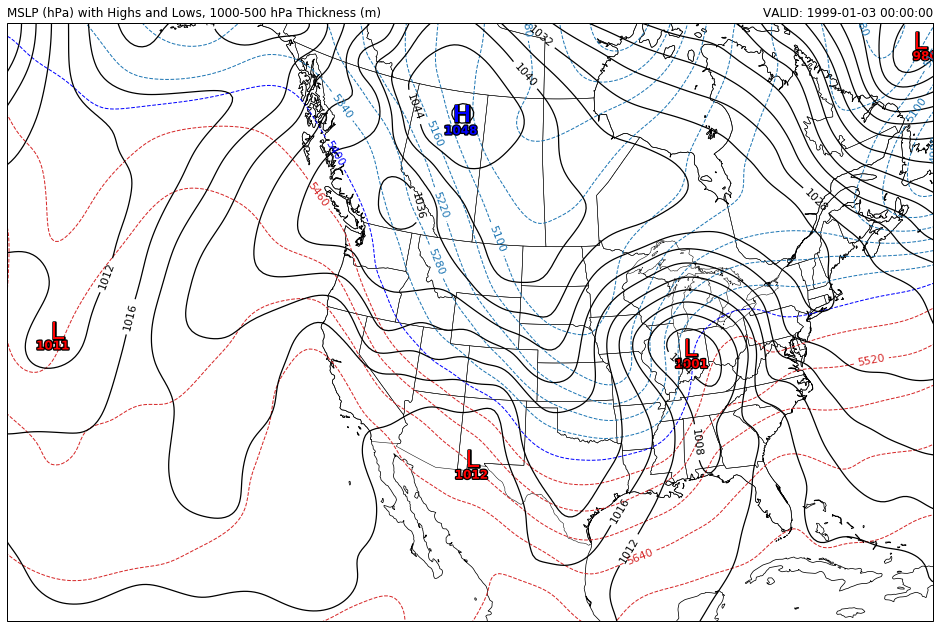

In [5]:
fig = plt.figure(1, figsize=(17., 11.))
ax = plt.subplot(111, projection=mapproj)

# Set extent and plot map lines
ax.set_extent([-145., -70, 20., 60.], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot thickness with multiple colors
clevs = (np.arange(0, 5400, 60),
         np.array([5400]),
         np.arange(5460, 7000, 60))
colors = ('tab:blue', 'b', 'tab:red')
kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
for clevthick, color in zip(clevs, colors):
    cs = ax.contour(lons, lats, thickness_1000_500, levels=clevthick, colors=color,
                    linewidths=1.0, linestyles='dashed', transform=dataproj)
    plt.clabel(cs, **kw_clabels)

# Plot MSLP
clevmslp = np.arange(800., 1120., 4)
cs2 = ax.contour(lons, lats, mslp, clevmslp, colors='k', linewidths=1.25,
                 linestyles='solid', transform=dataproj)
plt.clabel(cs2, **kw_clabels)

# Use definition to plot H/L symbols
plot_maxmin_points(ax,lons, lats, mslp, 'max', 50, symbol='H', color='b',  transform=dataproj)
plot_maxmin_points(ax,lons, lats, mslp, 'min', 25, symbol='L', color='r', transform=dataproj)

# Put on some titles
plt.title('MSLP (hPa) with Highs and Lows, 1000-500 hPa Thickness (m)', loc='left')
plt.title('VALID: {}'.format(vtime[0]), loc='right')

plt.show()